In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
# 지표 데이터 가져오기
stock_data = pd.read_excel('../index_Infomation_v0.1.xlsx')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.head(3)

,Date,nasdaq_Close,snp500_Close,DJI_Close,KOSPI_Close,samsung_PER,samsung_PBR,samsung_ROE,apple_PER,apple_PBR,...,중앙은행 기준금리,생산자물가지수,수입물가지수,소비자물가지수,수입,수출,경상수지,소비자심리지수,기업경기실사지수,foreign_exchange_reserves
0,2014-11-01,4630.74023,2018.05004,17390.5195,1964.43,6.29,1.47,0.233704,3.794397,5.922144,...,2.0,100.12,113.7,94.015,105.99,107.37,10582.7,103.3,71,"3,631"
1,2014-11-02,4630.74023,2018.05004,17390.5195,1964.43,6.29,1.47,0.233704,3.794397,5.922144,...,2.0,100.12,113.7,94.015,105.99,107.37,10582.7,103.3,71,"3,631"
2,2014-11-03,4638.91015,2017.81005,17366.2402,1952.97,6.24,1.45,0.232372,3.843583,5.998912,...,2.0,100.12,113.7,94.015,105.99,107.37,10582.7,103.3,71,"3,631"


In [4]:
stock_data.columns

Index(['Date', 'nasdaq_Close', 'snp500_Close', 'DJI_Close', 'KOSPI_Close',
       'samsung_PER', 'samsung_PBR', 'samsung_ROE', 'apple_PER', 'apple_PBR',
       'gold_Close', 'oil_Close', 'samsung_Close', 'apple_Close',
       'dollar_to_won_Close', 'samsung_market_cap', 'apple_market_cap',
       '미국 국내총생산(GDP) 전분기 대비', '미국 중앙은행 기준금리', '미국 수입 물가 지수 전년대비',
       '미국 생산자물가지수(PPI) 전년대비', '미국 소비자물가지수(CPI) 전년대비', '미국 소비자물가지수(CPI) 전월대비',
       '미국 무역수지', '미국 CB 소비자신뢰지수', '미국 개인지출 전월대비', '미국 소매판매 전월대비',
       '미국 미시간대 소비자심리지수', '국내 총 생산', 'M2 통화공급 (말잔)', 'M2 통화공급 (평잔)',
       '중앙은행 기준금리', '생산자물가지수', '수입물가지수', '소비자물가지수', '수입', '수출', '경상수지',
       '소비자심리지수', '기업경기실사지수', 'foreign_exchange_reserves'],
      dtype='object')

In [5]:
compare1 = "apple"  # samsung, apple
compare2 = "US Base Index"
compare2data = "미국 중앙은행 기준금리"

In [6]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3530 entries, 0 to 3529
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       3530 non-null   datetime64[ns]
 1   nasdaq_Close               3530 non-null   float64       
 2   snp500_Close               3530 non-null   float64       
 3   DJI_Close                  3530 non-null   float64       
 4   KOSPI_Close                3530 non-null   float64       
 5   samsung_PER                3530 non-null   float64       
 6   samsung_PBR                3530 non-null   float64       
 7   samsung_ROE                3530 non-null   float64       
 8   apple_PER                  3530 non-null   float64       
 9   apple_PBR                  3530 non-null   float64       
 10  gold_Close                 3530 non-null   float64       
 11  oil_Close                  3530 non-null   float64       
 12  samsun

In [30]:
# 필요한 데이터만 가져오기
df = stock_data[['Date', f'{compare1}_Close', f'{compare2data}', 'dollar_to_won_Close']]
df['US_GDP_KRW'] = round(df[f'{compare2data}'] * df['dollar_to_won_Close'])
df.head(3)

C:\Users\4호실-8\AppData\Local\Temp\ipykernel_9924\1346086512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['US_GDP_KRW'] = round(df[f'{compare2data}'] * df['dollar_to_won_Close'])


,Date,apple_Close,미국 중앙은행 기준금리,dollar_to_won_Close,US_GDP_KRW
Date,,,,,
2014-11-01,2014-11-01,27.00,0.09,1053.80004,95.0
2014-11-02,2014-11-02,27.00,0.09,1053.80004,95.0
2014-11-03,2014-11-03,27.35,0.09,1051.19995,95.0


In [31]:
def normalize_data(series):
    # MinMaxScaler를 사용하여 데이터를 -1과 1 사이로 정규화
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(series.values.reshape(-1, 1))

In [32]:
def Regression(compare1, compare2data, compare2):
    # 데이터 정규화
    stock_data[f'{compare1}_Close_Normalized'] = normalize_data(stock_data[f'{compare1}_Close'])
    stock_data[f'{compare2data}_Normalized'] = normalize_data(stock_data[f'{compare2data}'])

    # 선형 회귀 분석
    X = stock_data[f'{compare1}_Close_Normalized']
    y = stock_data[f'{compare2data}_Normalized']
    X = sm.add_constant(X)  # 상수항 추가
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)

    # 회귀 분석 결과 출력
    print(model.summary())

    # 산점도 및 회귀선 그래프
    plt.scatter(stock_data[f'{compare2data}_Normalized'], stock_data[f'{compare1}_Close_Normalized'], label='Data points')
    plt.plot(stock_data[f'{compare2data}_Normalized'], predictions, color='red', label='Regression line')
    plt.xlabel(f'{compare2} (Normalized)')
    plt.ylabel(f'{compare1} (Normalized)')
    plt.legend()
    plt.show()

In [33]:
Regression(compare1, compare2data)

TypeError: Regression() missing 1 required positional argument: 'compare2'

In [34]:
def Granger(compare1, compare2data, compare2, stock_data=stock_data):
    if f'{compare1}_Close' not in stock_data.columns or compare2data not in stock_data.columns:
        raise KeyError(f"Columns {compare1}_Close and/or {compare2data} not found in the provided DataFrame")
    
    max_lag = 2
    result1 = grangercausalitytests(stock_data[[f'{compare1}_Close', compare2data]], max_lag, verbose=True)
    result2 = coint_johansen(stock_data[[f'{compare1}_Close', compare2data]], det_order=-1, k_ar_diff=1)
    
    return result1, result2.lr1, result2.cvt

In [35]:
Granger(compare1, compare2data)

TypeError: Granger() missing 1 required positional argument: 'compare2'

In [36]:

def rolling_correlation_and_granger_test(compare1, compare2data, compare2, window_size=30, max_lag=5, stock_data=stock_data):
    col1 = f'{compare1}_Close'
    col2 = compare2data

    # 날짜 인덱스 설정
    if not pd.api.types.is_datetime64_any_dtype(stock_data.index):
        stock_data.index = pd.to_datetime(stock_data['Date'])
        stock_data = stock_data.drop(columns=['Date'])

    # 롤링 상관관계 계산
    rolling_corr = stock_data[col1].rolling(window=window_size).corr(stock_data[col2]).dropna()

    # 무한 값과 NaN 값 제거
    rolling_corr = rolling_corr[~rolling_corr.isin([np.inf, -np.inf])].dropna()

    # 롤링 상관관계 그래프 그리기
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_corr)
    plt.xlabel('Date')
    plt.ylabel('Rolling Correlation')
    plt.title(f'Dynamic Correlation between {col1} and {compare2}')
    plt.show()

    # 롤링 상관관계의 히스토그램 그리기
    plt.figure(figsize=(10, 6))
    plt.hist(rolling_corr, bins=30, edgecolor='k')
    plt.xlabel('Rolling Correlation')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Rolling Correlations between {col1} and {compare2}')
    plt.show()

    # 그랜저 인과성 테스트
    granger_test_result = grangercausalitytests(stock_data[[col1, col2]], max_lag, verbose=True)

    return rolling_corr, granger_test_result

In [37]:
rolling_correlation_and_granger_test(compare1, compare2data)

TypeError: rolling_correlation_and_granger_test() missing 1 required positional argument: 'compare2'

In [46]:
import pandas as pd

# 주어진 데이터
data = {
    'samsung_Close': ['금', '미국 GDP', '나스닥', 'S&P500', '다우존스', '코스피', '미국무역수지', '외환보유액', 
                '미국 개인지출 전월대피', '미국 소매판매 전월대비', '미국 소비자물가지수(CPI) 전년대비', 
                '미국 소비자물가지수(CPI) 전월대비', None],
    'apple_Close': ['금', '나스닥', 'US GDP', 'USCBConsumer', '미국 미시간대 소비자심리지수', '미국 개인지출 전월대비', 
                '미국 소매판매 전월대비', '환율', '미국 무역지수', '미국수입물가지수 전년대비', '미국 생산자물가지수(PPI) 전년대비', 
                '미국 소비자물가지수(CPI) 전년대비', '미국 소비자물가지수(CPI) 전월대비']
}

# 데이터프레임 생성
df = pd.DataFrame(data)

# 매핑된 결과
samsung_Close_english = ['gold_Close', 'US GDP', 'nasdaq_Close', 'snp500_Close', 'DJI_Close', 'KOSPI_Close', 
                         'US Trade Balance', 'Foreign Exchange Reserves', 'US Personal Spending MoM', 'US Retail Sales MoM', 
                         'US CPI YoY', 'US CPI MoM', None]

apple_Close_english = ['gold_Close', 'nasdaq_Close', 'US GDP', 'US Consumer Confidence Index', 'US Michigan Consumer Sentiment Index', 
                       'US Personal Spending MoM', 'US Retail Sales MoM', 'USD/KRW Exchange Rate', 'US Trade Balance', 
                       'US Import Price Index YoY', 'US PPI YoY', 'US CPI YoY', 'US CPI MoM']

# 새로운 데이터프레임 생성
df['samsung_Close_english'] = samsung_Close_english
df['apple_Close_english'] = apple_Close_english

# 결과 출력
df


,samsung_Close,apple_Close,samsung_Close_english,apple_Close_english
0,금,금,gold_Close,gold_Close
1,미국 GDP,나스닥,US GDP,nasdaq_Close
2,나스닥,US GDP,nasdaq_Close,US GDP
3,S&P500,USCBConsumer,snp500_Close,US Consumer Confidence Index
4,다우존스,미국 미시간대 소비자심리지수,DJI_Close,US Michigan Consumer Sentiment Index
5,코스피,미국 개인지출 전월대비,KOSPI_Close,US Personal Spending MoM
6,미국무역수지,미국 소매판매 전월대비,US Trade Balance,US Retail Sales MoM
7,외환보유액,환율,Foreign Exchange Reserves,USD/KRW Exchange Rate
8,미국 개인지출 전월대피,미국 무역지수,US Personal Spending MoM,US Trade Balance
9,미국 소매판매 전월대비,미국수입물가지수 전년대비,US Retail Sales MoM,US Import Price Index YoY


Calling Granger with samsung, 미국 소매판매 전월대비, US Retail Sales MoM

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3771  , p=0.2407  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=1.3783  , p=0.2404  , df=1
likelihood ratio test: chi2=1.3780  , p=0.2404  , df=1
parameter F test:         F=1.3771  , p=0.2407  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6939  , p=0.4997  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=1.3897  , p=0.4992  , df=2
likelihood ratio test: chi2=1.3894  , p=0.4992  , df=2
parameter F test:         F=0.6939  , p=0.4997  , df_denom=3523, df_num=2
Granger result: ({1: ({'ssr_ftest': (1.3771123326582178, 0.24067289675096376, 3526.0, 1), 'ssr_chi2test': (1.3782840107631453, 0.24039365907596086, 1), 'lrtest': (1.3780149299564073, 0.24043956653673976, 1), 'params_ftest': (1.3771123327128474, 0.24067289674157305, 3526.0, 1.0)}, [<statsmodels.regression.linear_model.Regressio

c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


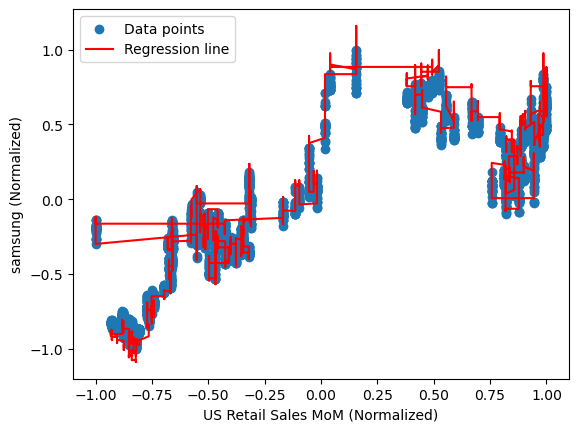

Regression result: None
Calling rolling_correlation_and_granger_test with samsung, 미국 소매판매 전월대비, US Retail Sales MoM


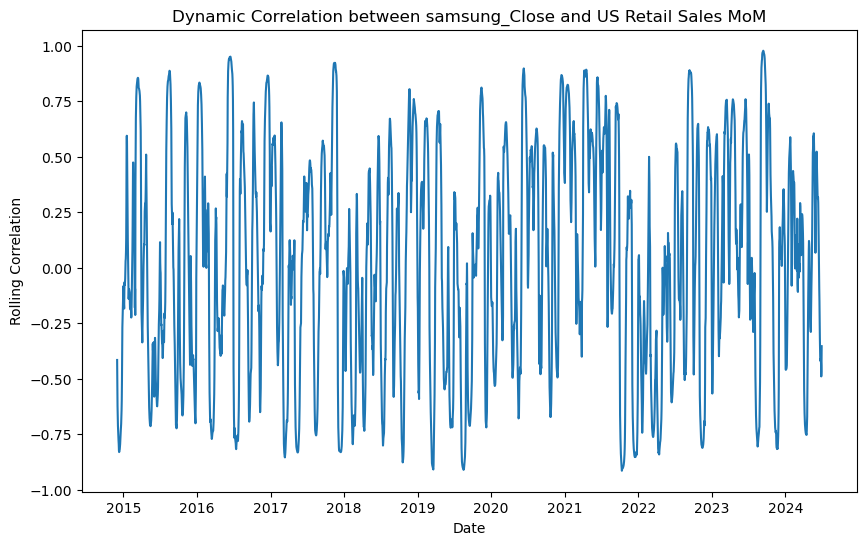

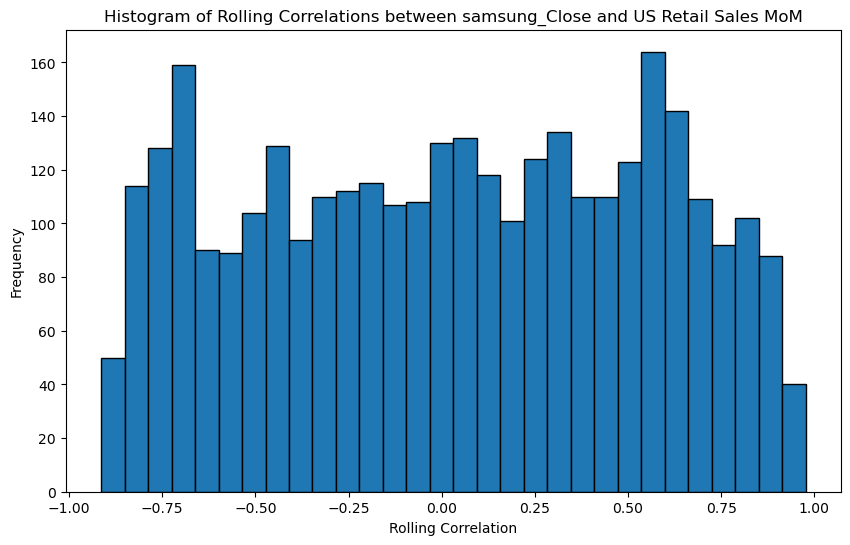

c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3771  , p=0.2407  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=1.3783  , p=0.2404  , df=1
likelihood ratio test: chi2=1.3780  , p=0.2404  , df=1
parameter F test:         F=1.3771  , p=0.2407  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6939  , p=0.4997  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=1.3897  , p=0.4992  , df=2
likelihood ratio test: chi2=1.3894  , p=0.4992  , df=2
parameter F test:         F=0.6939  , p=0.4997  , df_denom=3523, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0665  , p=0.3620  , df_denom=3520, df_num=3
ssr based chi2 test:   chi2=3.2057  , p=0.3610  , df=3
likelihood ratio test: chi2=3.2043  , p=0.3612  , df=3
parameter F test:         F=1.0665  , p=0.3620  , df_denom=3520, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2340  , p=0.

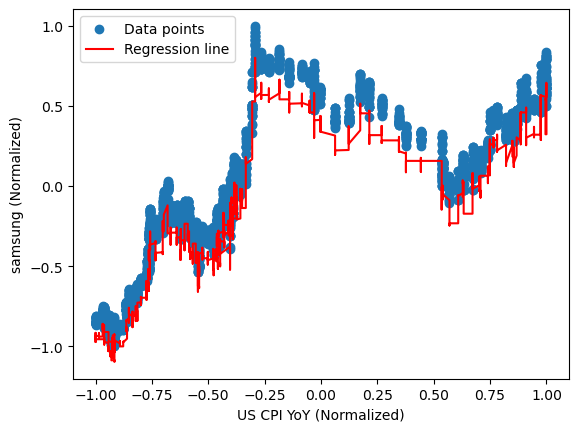

Regression result: None
Calling rolling_correlation_and_granger_test with samsung, 미국 소비자물가지수(CPI) 전년대비, US CPI YoY


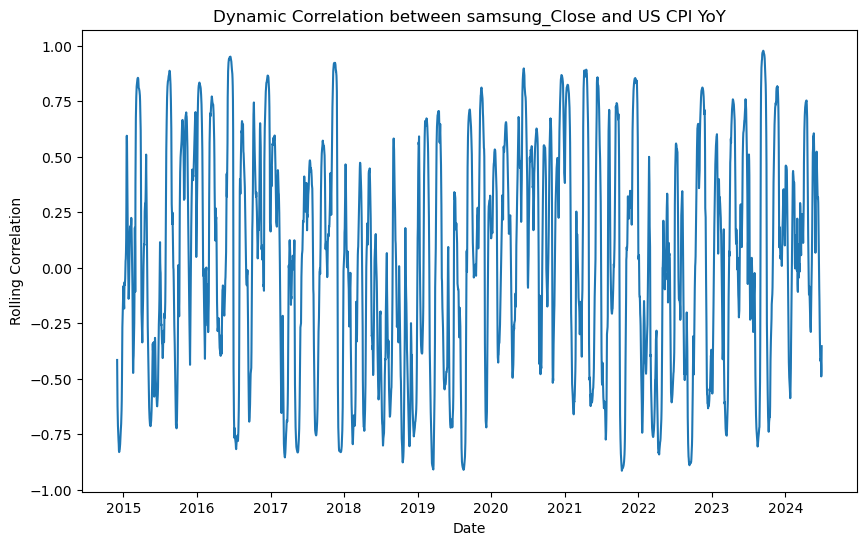

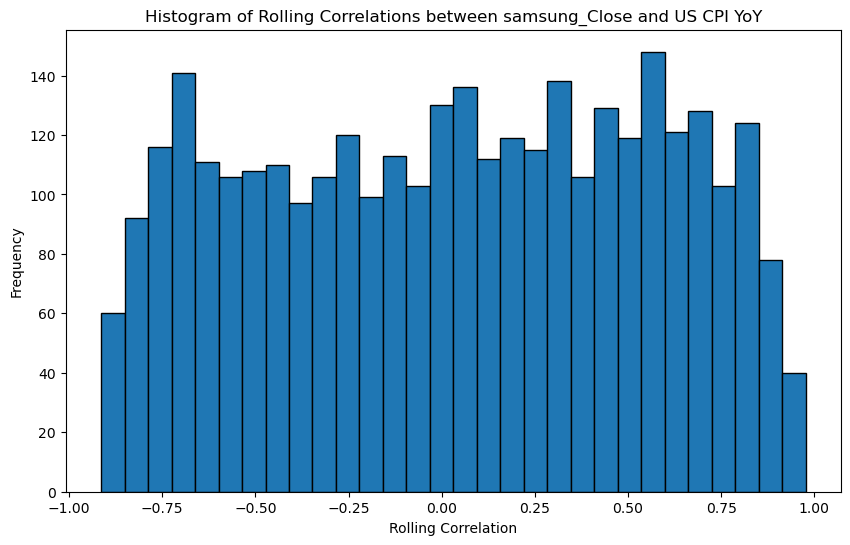

c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2756  , p=0.2588  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=1.2767  , p=0.2585  , df=1
likelihood ratio test: chi2=1.2764  , p=0.2586  , df=1
parameter F test:         F=1.2756  , p=0.2588  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0945  , p=0.1233  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=4.1949  , p=0.1228  , df=2
likelihood ratio test: chi2=4.1924  , p=0.1229  , df=2
parameter F test:         F=2.0945  , p=0.1233  , df_denom=3523, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5880  , p=0.1901  , df_denom=3520, df_num=3
ssr based chi2 test:   chi2=4.7734  , p=0.1892  , df=3
likelihood ratio test: chi2=4.7701  , p=0.1894  , df=3
parameter F test:         F=1.5880  , p=0.1901  , df_denom=3520, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4592  , p=0.

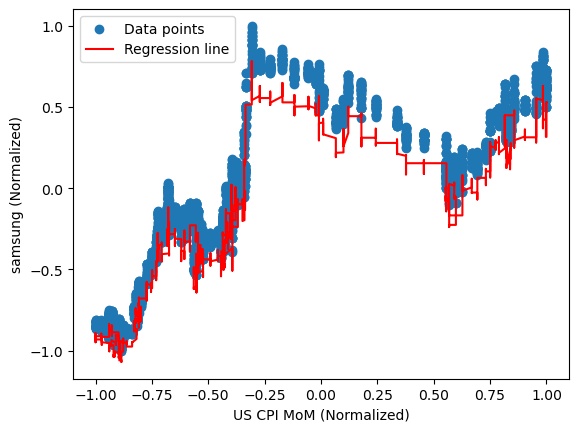

Regression result: None
Calling rolling_correlation_and_granger_test with samsung, 미국 소비자물가지수(CPI) 전월대비, US CPI MoM


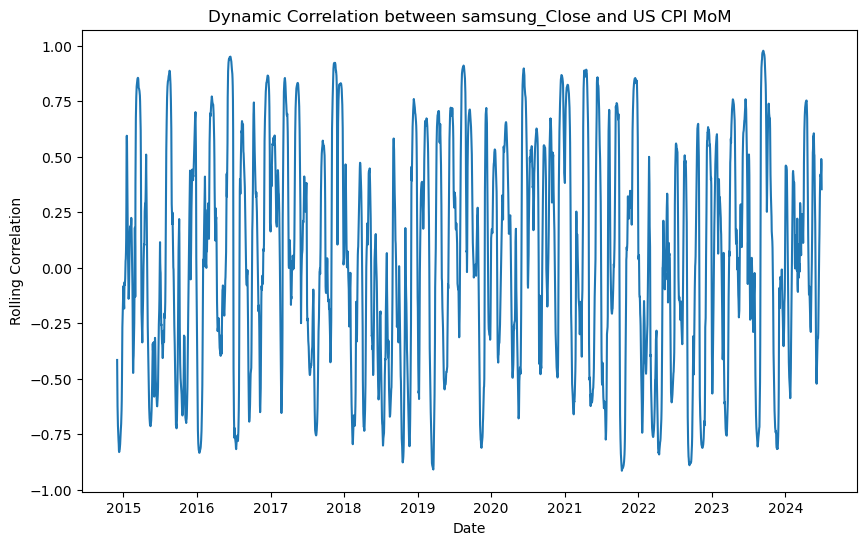

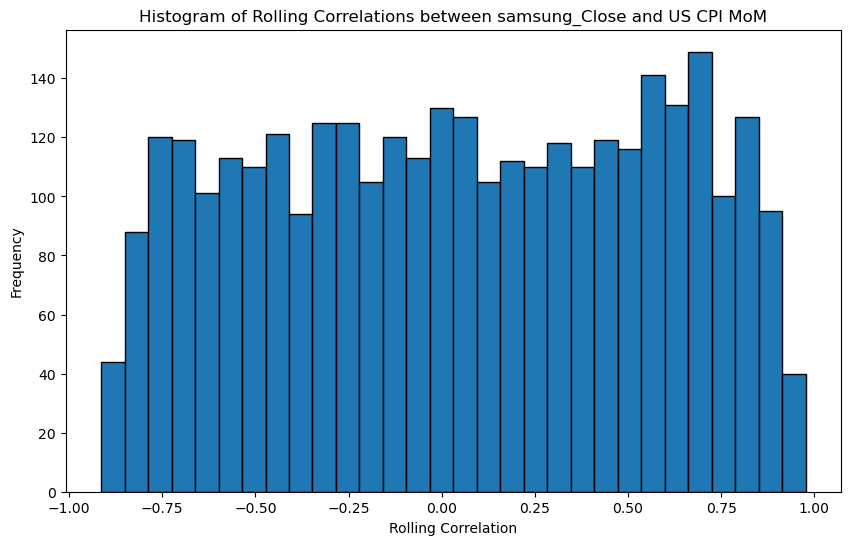


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1135  , p=0.2914  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=1.1145  , p=0.2911  , df=1
likelihood ratio test: chi2=1.1143  , p=0.2912  , df=1
parameter F test:         F=1.1135  , p=0.2914  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3424  , p=0.0963  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=4.6914  , p=0.0958  , df=2
likelihood ratio test: chi2=4.6882  , p=0.0959  , df=2
parameter F test:         F=2.3424  , p=0.0963  , df_denom=3523, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8644  , p=0.1334  , df_denom=3520, df_num=3
ssr based chi2 test:   chi2=5.6042  , p=0.1325  , df=3
likelihood ratio test: chi2=5.5997  , p=0.1328  , df=3
parameter F test:         F=1.8644  , p=0.1334  , df_denom=3520, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6397  , p=0.

c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [52]:
# 함수 호출
for index, row in df.iterrows():
    if row['samsung_Close'] is not None:
        compare1 = "samsung"
        compare2data = row['samsung_Close']
        compare2 = row['samsung_Close_english']
        if compare2data in stock_data.columns:
            print(f"Calling Granger with {compare1}, {compare2data}, {compare2}")
            granger_result = Granger(compare1, compare2data, compare2)
            print(f"Granger result: {granger_result}")
            
            print(f"Calling Regression with {compare1}, {compare2data}, {compare2}")
            regression_result = Regression(compare1, compare2data, compare2)
            print(f"Regression result: {regression_result}")
            
            print(f"Calling rolling_correlation_and_granger_test with {compare1}, {compare2data}, {compare2}")
            rolling_corr_result = rolling_correlation_and_granger_test(compare1, compare2data, compare2)
            print(f"Rolling correlation and Granger result: {rolling_corr_result}")

c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Calling Granger with apple, 미국 미시간대 소비자심리지수, US Michigan Consumer Sentiment Index

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7354  , p=0.0296  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=4.7395  , p=0.0295  , df=1
likelihood ratio test: chi2=4.7363  , p=0.0295  , df=1
parameter F test:         F=4.7354  , p=0.0296  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.5962  , p=0.0002  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=17.2167 , p=0.0002  , df=2
likelihood ratio test: chi2=17.1748 , p=0.0002  , df=2
parameter F test:         F=8.5962  , p=0.0002  , df_denom=3523, df_num=2
Granger result: ({1: ({'ssr_ftest': (4.735436529811999, 0.02961352156350998, 3526.0, 1), 'ssr_chi2test': (4.739465545577579, 0.029478227638403038, 1), 'lrtest': (4.736285828608743, 0.029532764499389373, 1), 'params_ftest': (4.7354365298127075, 0.02961352156348644, 3526.0, 1.0)}, [<statsmodels.regression.linea

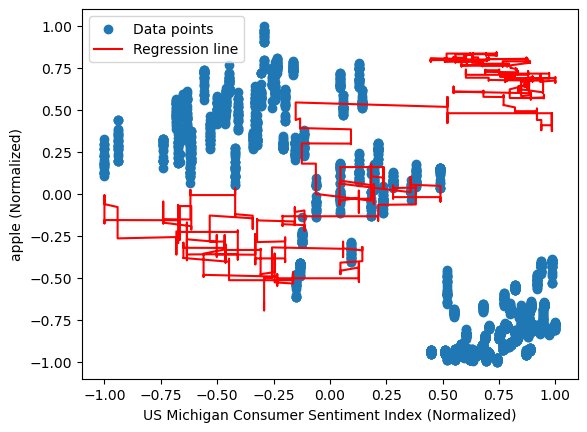

Regression result: None
Calling rolling_correlation_and_granger_test with apple, 미국 미시간대 소비자심리지수, US Michigan Consumer Sentiment Index


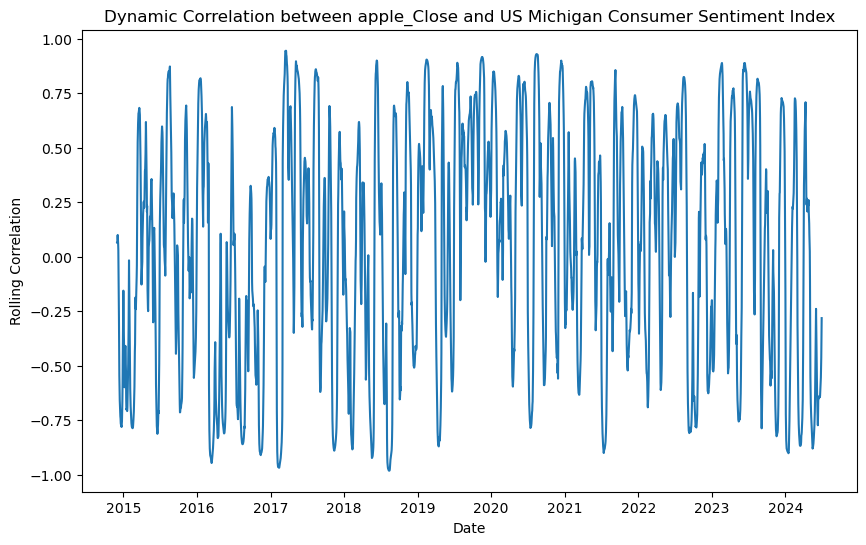

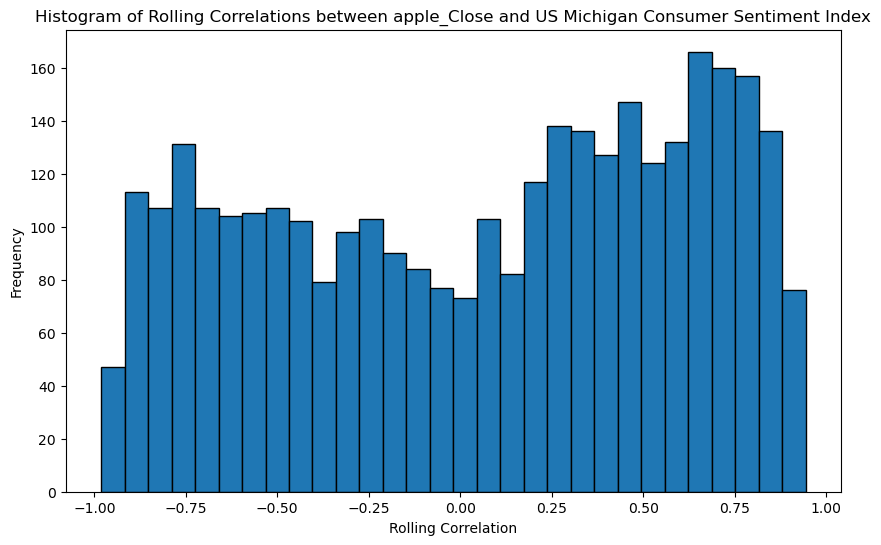

c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7354  , p=0.0296  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=4.7395  , p=0.0295  , df=1
likelihood ratio test: chi2=4.7363  , p=0.0295  , df=1
parameter F test:         F=4.7354  , p=0.0296  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.5962  , p=0.0002  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=17.2167 , p=0.0002  , df=2
likelihood ratio test: chi2=17.1748 , p=0.0002  , df=2
parameter F test:         F=8.5962  , p=0.0002  , df_denom=3523, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1383  , p=0.0004  , df_denom=3520, df_num=3
ssr based chi2 test:   chi2=18.4514 , p=0.0004  , df=3
likelihood ratio test: chi2=18.4033 , p=0.0004  , df=3
parameter F test:         F=6.1383  , p=0.0004  , df_denom=3520, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7520  , p=0.

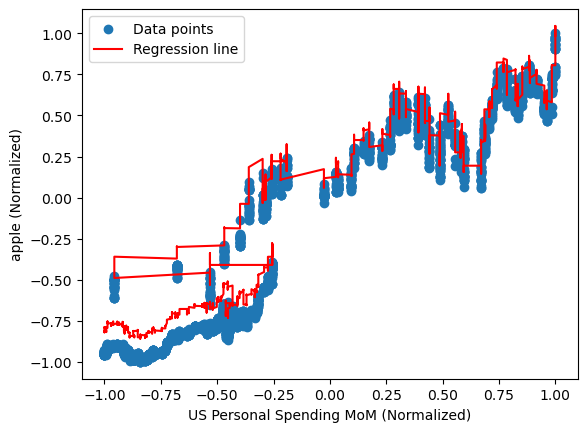

Regression result: None
Calling rolling_correlation_and_granger_test with apple, 미국 개인지출 전월대비, US Personal Spending MoM


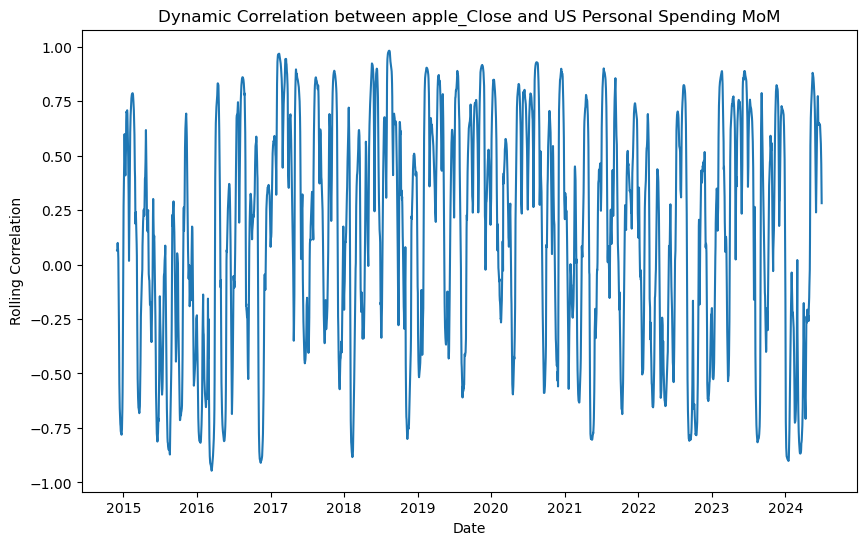

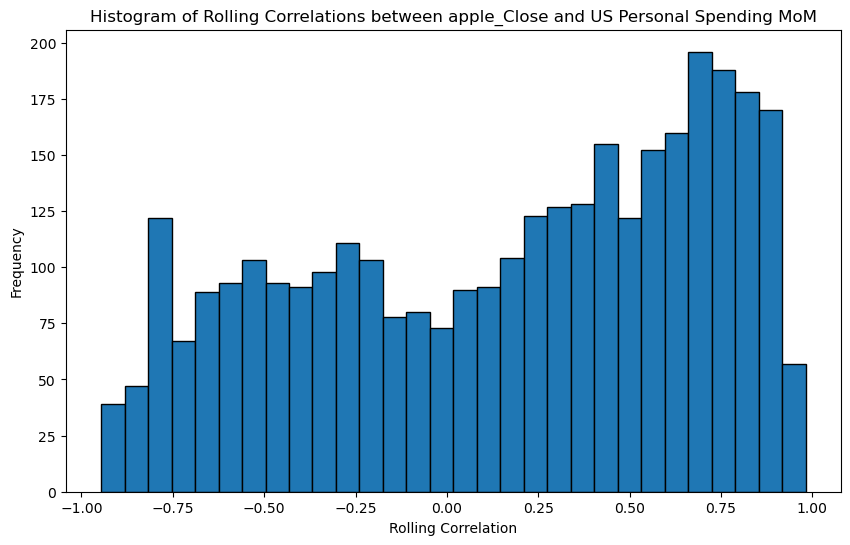

c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9446  , p=0.1633  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=1.9463  , p=0.1630  , df=1
likelihood ratio test: chi2=1.9457  , p=0.1630  , df=1
parameter F test:         F=1.9446  , p=0.1633  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2059  , p=0.0406  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=6.4209  , p=0.0403  , df=2
likelihood ratio test: chi2=6.4151  , p=0.0405  , df=2
parameter F test:         F=3.2059  , p=0.0406  , df_denom=3523, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0700  , p=0.1020  , df_denom=3520, df_num=3
ssr based chi2 test:   chi2=6.2223  , p=0.1013  , df=3
likelihood ratio test: chi2=6.2168  , p=0.1015  , df=3
parameter F test:         F=2.0700  , p=0.1020  , df_denom=3520, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2439  , p=0.

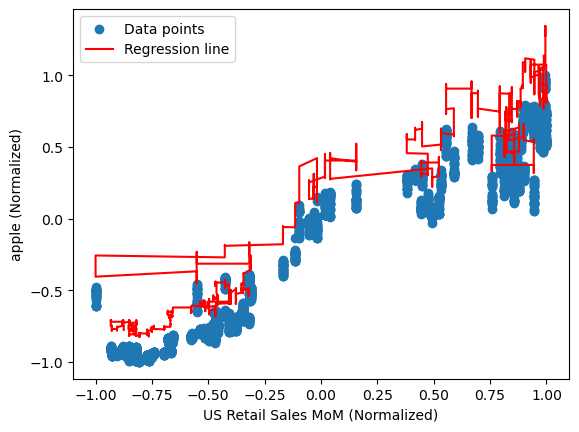

Regression result: None
Calling rolling_correlation_and_granger_test with apple, 미국 소매판매 전월대비, US Retail Sales MoM


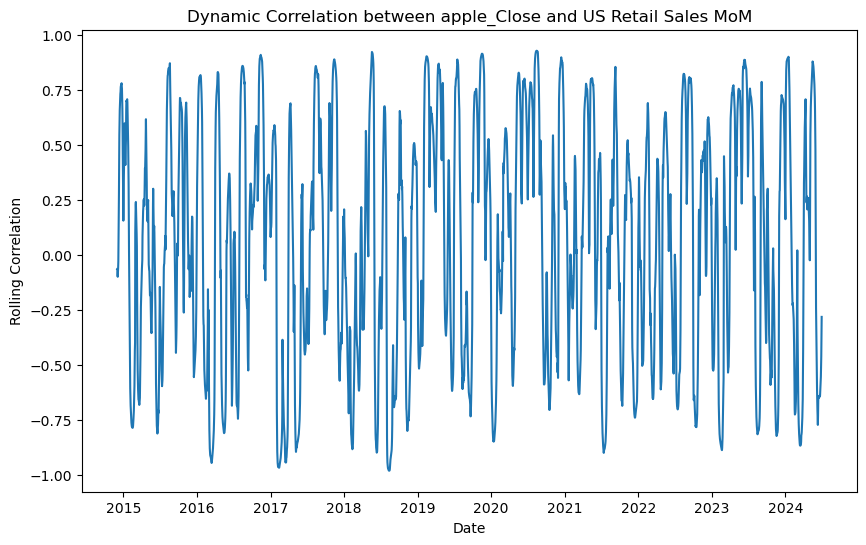

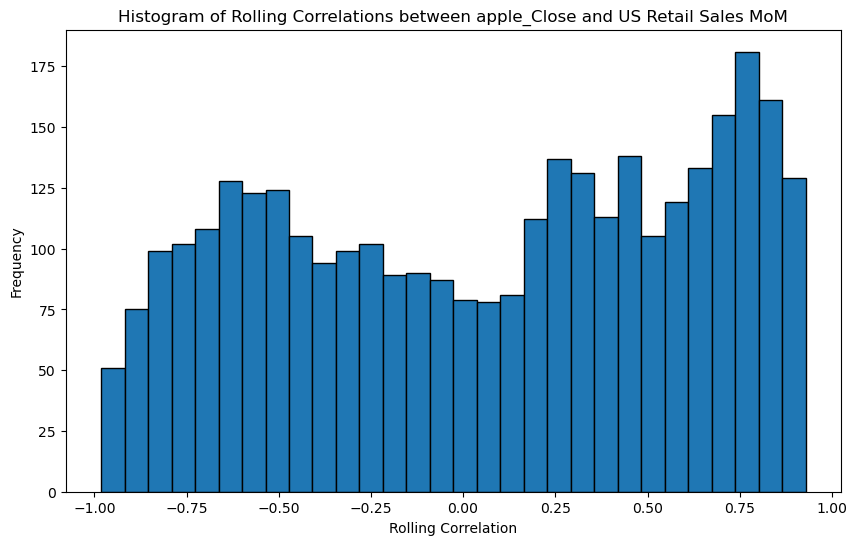

c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1630  , p=0.0754  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=3.1657  , p=0.0752  , df=1
likelihood ratio test: chi2=3.1642  , p=0.0753  , df=1
parameter F test:         F=3.1630  , p=0.0754  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8053  , p=0.0606  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=5.6186  , p=0.0602  , df=2
likelihood ratio test: chi2=5.6141  , p=0.0604  , df=2
parameter F test:         F=2.8053  , p=0.0606  , df_denom=3523, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0878  , p=0.0997  , df_denom=3520, df_num=3
ssr based chi2 test:   chi2=6.2759  , p=0.0989  , df=3
likelihood ratio test: chi2=6.2703  , p=0.0992  , df=3
parameter F test:         F=2.0878  , p=0.0997  , df_denom=3520, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2126  , p=0.

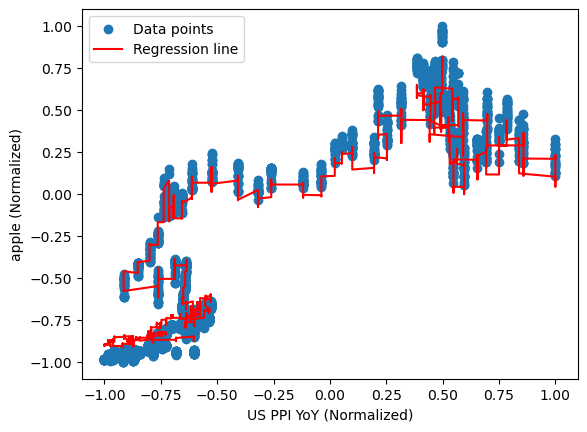

Regression result: None
Calling rolling_correlation_and_granger_test with apple, 미국 생산자물가지수(PPI) 전년대비, US PPI YoY


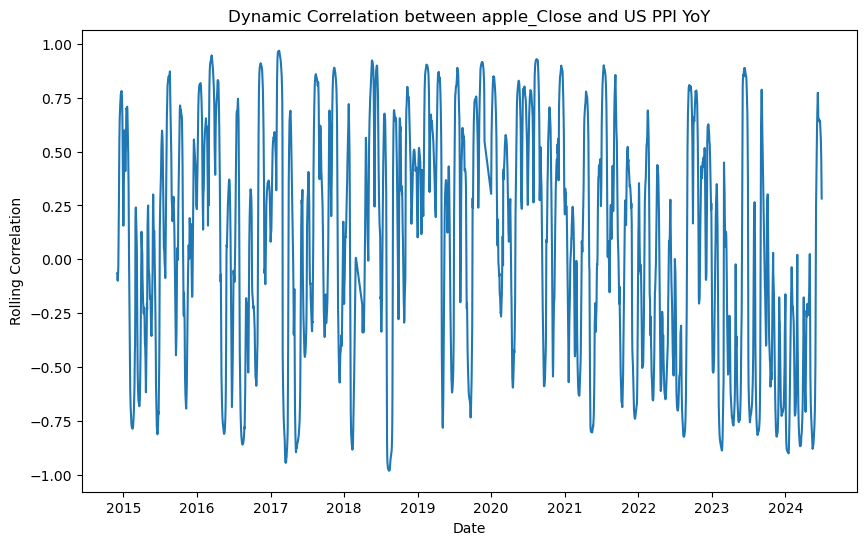

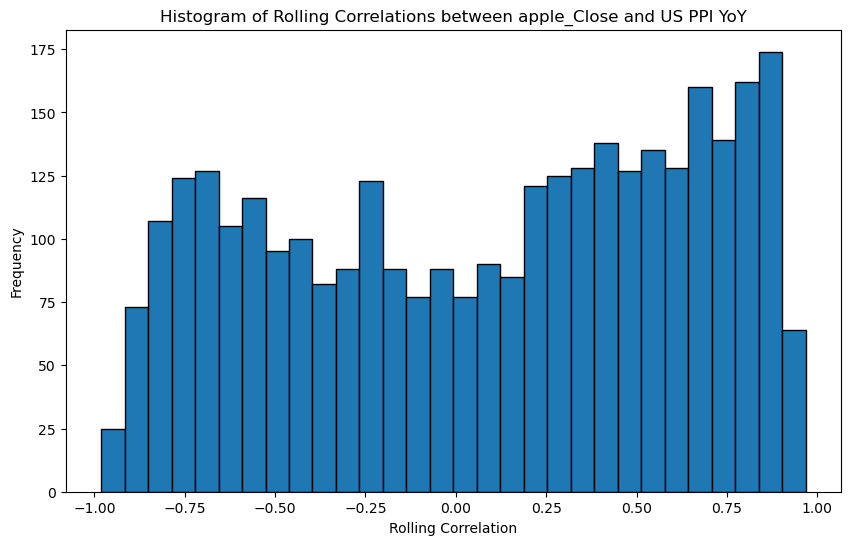

c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1902  , p=0.6628  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=0.1904  , p=0.6626  , df=1
likelihood ratio test: chi2=0.1904  , p=0.6626  , df=1
parameter F test:         F=0.1902  , p=0.6628  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1494  , p=0.8612  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=0.2993  , p=0.8610  , df=2
likelihood ratio test: chi2=0.2993  , p=0.8610  , df=2
parameter F test:         F=0.1494  , p=0.8612  , df_denom=3523, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8343  , p=0.4749  , df_denom=3520, df_num=3
ssr based chi2 test:   chi2=2.5079  , p=0.4739  , df=3
likelihood ratio test: chi2=2.5070  , p=0.4740  , df=3
parameter F test:         F=0.8343  , p=0.4749  , df_denom=3520, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0388  , p=0.

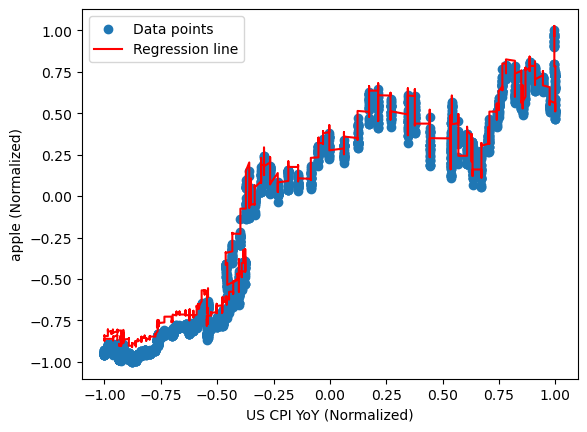

Regression result: None
Calling rolling_correlation_and_granger_test with apple, 미국 소비자물가지수(CPI) 전년대비, US CPI YoY


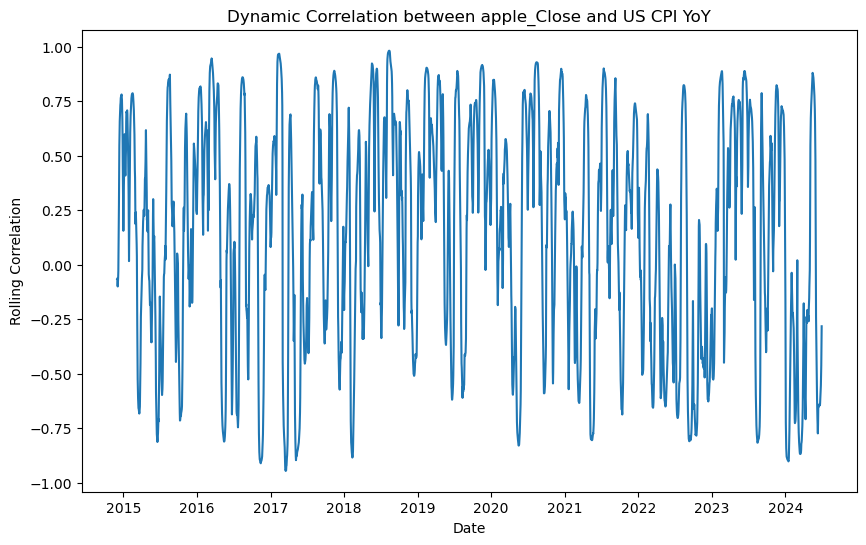

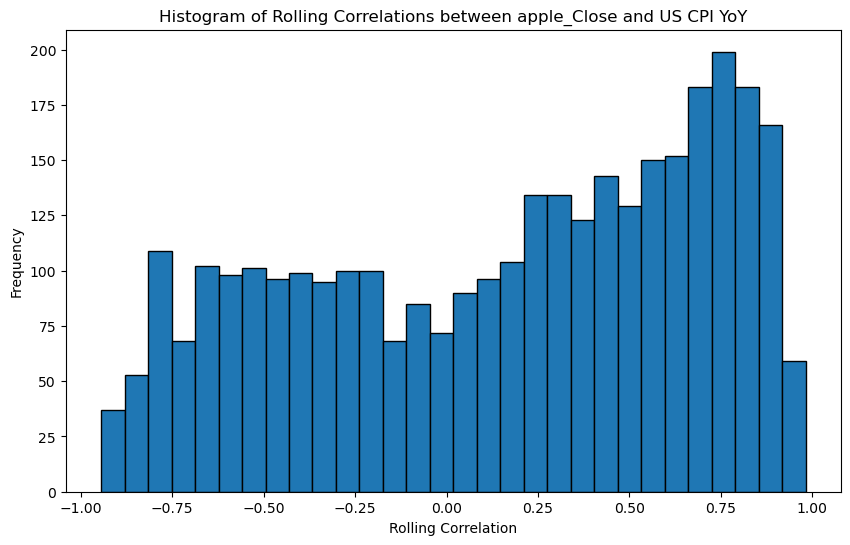

c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6198  , p=0.1056  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=2.6220  , p=0.1054  , df=1
likelihood ratio test: chi2=2.6210  , p=0.1055  , df=1
parameter F test:         F=2.6198  , p=0.1056  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2207  , p=0.2951  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=2.4449  , p=0.2945  , df=2
likelihood ratio test: chi2=2.4440  , p=0.2946  , df=2
parameter F test:         F=1.2207  , p=0.2951  , df_denom=3523, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3788  , p=0.2473  , df_denom=3520, df_num=3
ssr based chi2 test:   chi2=4.1448  , p=0.2463  , df=3
likelihood ratio test: chi2=4.1423  , p=0.2465  , df=3
parameter F test:         F=1.3788  , p=0.2473  , df_denom=3520, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5610  , p=0.

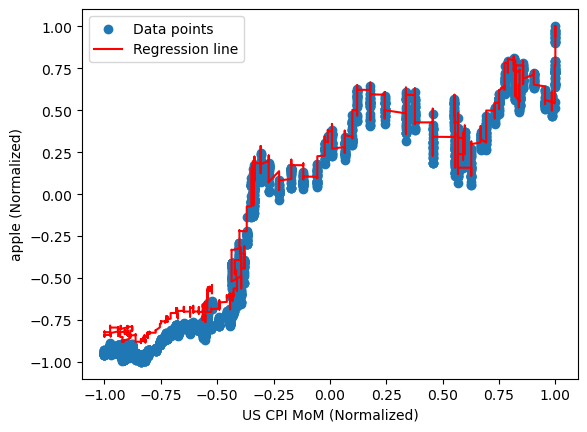

Regression result: None
Calling rolling_correlation_and_granger_test with apple, 미국 소비자물가지수(CPI) 전월대비, US CPI MoM


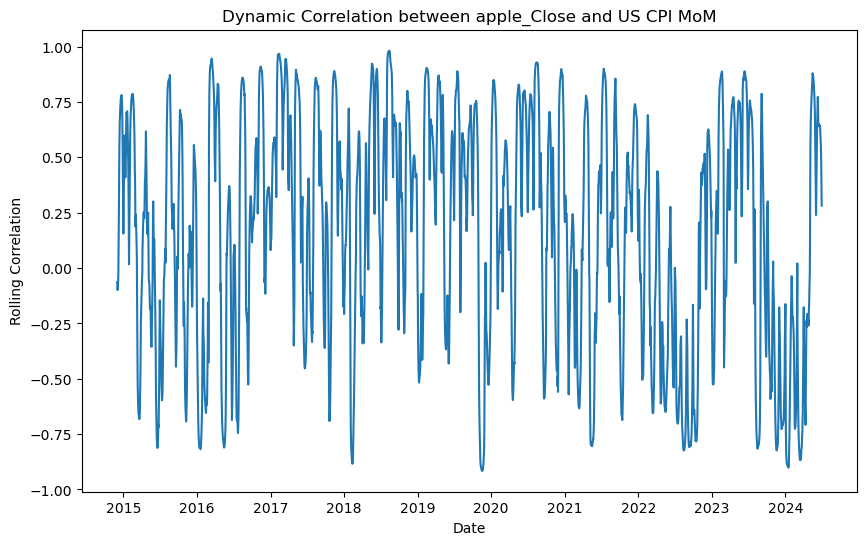

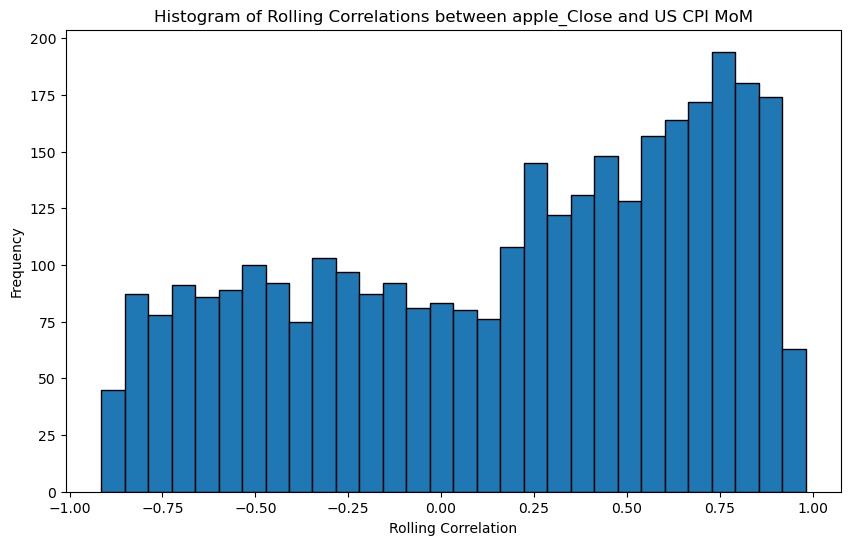


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9200  , p=0.0876  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=2.9225  , p=0.0874  , df=1
likelihood ratio test: chi2=2.9213  , p=0.0874  , df=1
parameter F test:         F=2.9200  , p=0.0876  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8306  , p=0.1605  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=3.6664  , p=0.1599  , df=2
likelihood ratio test: chi2=3.6645  , p=0.1601  , df=2
parameter F test:         F=1.8306  , p=0.1605  , df_denom=3523, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3987  , p=0.2412  , df_denom=3520, df_num=3
ssr based chi2 test:   chi2=4.2045  , p=0.2402  , df=3
likelihood ratio test: chi2=4.2020  , p=0.2405  , df=3
parameter F test:         F=1.3987  , p=0.2412  , df_denom=3520, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4017  , p=0.

c:\Anaconda\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [53]:
# 함수 호출
for index, row in df.iterrows():
    if row['apple_Close'] is not None:
        compare1 = "apple"
        compare2data = row['apple_Close']
        compare2 = row['apple_Close_english']
        if compare2data in stock_data.columns:
            print(f"Calling Granger with {compare1}, {compare2data}, {compare2}")
            granger_result = Granger(compare1, compare2data, compare2)
            print(f"Granger result: {granger_result}")
            
            print(f"Calling Regression with {compare1}, {compare2data}, {compare2}")
            regression_result = Regression(compare1, compare2data, compare2)
            print(f"Regression result: {regression_result}")
            
            print(f"Calling rolling_correlation_and_granger_test with {compare1}, {compare2data}, {compare2}")
            rolling_corr_result = rolling_correlation_and_granger_test(compare1, compare2data, compare2)
            print(f"Rolling correlation and Granger result: {rolling_corr_result}")